In [89]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

In [101]:
#import train dataset
train = pd.read_csv('../../titanic/train.csv')

#import test dataset
test = pd.read_csv('../../titanic/test.csv')

#shuffle the training dataset
indices = np.arange(train.shape[0])
shuffled_indices = np.random.permutation(indices)
train = train.reindex(shuffled_indices)

#display shuffled data
display(train)

#separaing labels
train_label = train.pop('Survived')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
809,810,1,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.0,1,0,113806,53.1000,E8,S
483,484,1,3,"Turkula, Mrs. (Hedwig)",female,63.0,0,0,4134,9.5875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.6500,E67,S
392,393,0,3,"Gustafsson, Mr. Johan Birger",male,28.0,2,0,3101277,7.9250,NaN,S
301,302,1,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q
155,156,0,1,"Williams, Mr. Charles Duane",male,51.0,0,1,PC 17597,61.3792,NaN,C


In [91]:
#getting NaN counts for each feature
display(train.isna().sum())

# Group the data by sex and calculate the mean age for each group
average_age_by_sex = train.groupby('Sex')['Age'].mean()

# Fill NaN values in the Age column with the average age based on sex
train['Age'] = train.groupby('Sex')['Age'].apply(lambda x: x.fillna(x.mean()))

#dropping cabin feature as majority of feature populated with NaN
train = train.drop('Cabin', axis=1)


PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [92]:
#adding an honorific feature to the dataframe as that displays a person's social standing
def honorific(name):
    """Identifies the honorific of the person"""
    split_names = name.split(',')
    honorific = split_names[1].split()[0]
    return honorific

train['honorific'] = train['Name'].apply(lambda x: honorific(x))
display(train['honorific'].value_counts())

#given the minimal counts of some classes, honorific feature won't be ideal for testing
train = train.drop('honorific', axis=1)
display(train)

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Mme.           1
the            1
Jonkheer.      1
Lady.          1
Sir.           1
Don.           1
Capt.          1
Ms.            1
Name: honorific, dtype: int64

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
655,656,2,"Hickman, Mr. Leonard Mark",male,24.0,2,0,S.O.C. 14879,73.500,S
160,161,3,"Cribb, Mr. John Hatfield",male,44.0,0,1,371362,16.100,S
323,324,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22.0,1,1,248738,29.000,S
183,184,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.000,S
27,28,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.000,S
...,...,...,...,...,...,...,...,...,...,...
366,367,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.250,C
115,116,3,"Pekoniemi, Mr. Edvard",male,21.0,0,0,STON/O 2. 3101294,7.925,S
429,430,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.050,S
450,451,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.750,S


In [93]:
# create a family size feature
train['fam_size'] = train['SibSp'] + train['Parch']
display(train)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,fam_size
655,656,2,"Hickman, Mr. Leonard Mark",male,24.0,2,0,S.O.C. 14879,73.500,S,2
160,161,3,"Cribb, Mr. John Hatfield",male,44.0,0,1,371362,16.100,S,1
323,324,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22.0,1,1,248738,29.000,S,2
183,184,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.000,S,3
27,28,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.000,S,5
...,...,...,...,...,...,...,...,...,...,...,...
366,367,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.250,C,1
115,116,3,"Pekoniemi, Mr. Edvard",male,21.0,0,0,STON/O 2. 3101294,7.925,S,0
429,430,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.050,S,0
450,451,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.750,S,3


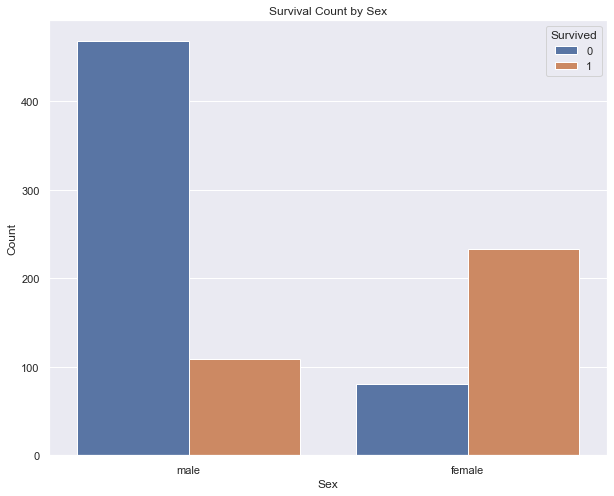

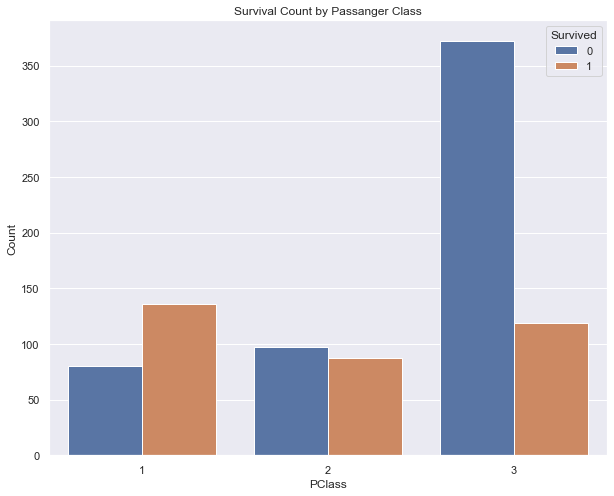

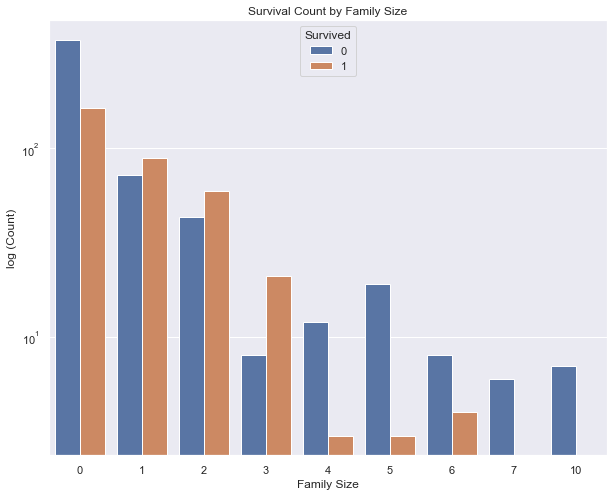

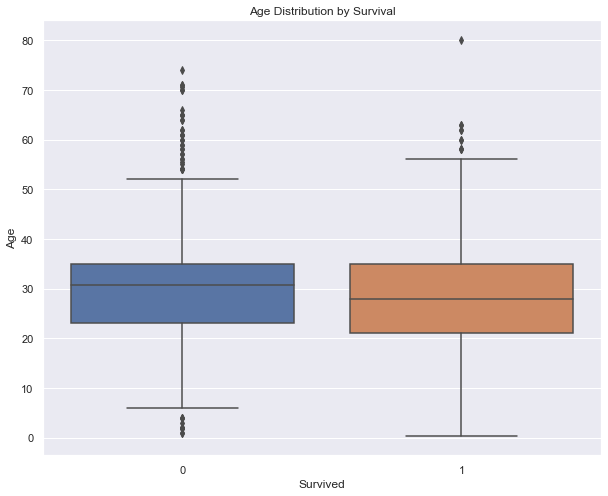

In [94]:
# understdaning relationship of features to survivability

# Plot of sex and survival
plt.figure(figsize=(10, 8))
sns.countplot(x=train['Sex'], hue=train_label)
plt.title('Survival Count by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Plot of Pclass and survival
plt.figure(figsize=(10, 8))
sns.countplot(x=train['Pclass'], hue=train_label)
plt.title('Survival Count by Passanger Class')
plt.xlabel('PClass')
plt.ylabel('Count')
plt.show()

# Plot of family size and survival
plt.figure(figsize=(10, 8))
sns.countplot(x=train['fam_size'], hue=train_label)
plt.title('Survival Count by Family Size')
plt.xlabel('Family Size')
plt.ylabel('log (Count)')
#changing scale for better comparison
plt.yscale('log')
plt.show()

# Boxplot of age and survival
plt.figure(figsize=(10, 8))
sns.boxplot(x=train_label, y=train['Age'])
plt.title('Age Distribution by Survival')
plt.xlabel('Survived')
plt.ylabel('Age')
plt.show()


In [99]:
#encoding features

# Define categorical columns
categorical_columns = ['Sex', 'Pclass', 'Embarked']
# Define numeric columns
numeric_columns = ['Age', 'fam_size']

# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(train[categorical_columns], prefix=categorical_columns, columns=categorical_columns)

# Concatenate the encoded features with the numeric features
encoded_features = pd.concat([one_hot_encoded, train[numeric_columns]], axis=1)

# display the encoded features
display(encoded_features.head())


,Sex_0,Sex_1,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2,Embarked_3,Age,fam_size
655,0,1,0,1,0,0,0,1,0,24.0,2
160,0,1,0,0,1,0,0,1,0,44.0,1
323,1,0,0,1,0,0,0,1,0,22.0,2
183,0,1,0,1,0,0,0,1,0,1.0,3
27,0,1,1,0,0,0,0,1,0,19.0,5


In [98]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Define categorical columns
categorical_columns = ['Sex', 'Pclass', 'Embarked']
# Define numeric columns
numeric_columns = ['Age', 'fam_size']

# Perform label encoding on categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    train[col] = label_encoder.fit_transform(train[col])

# Perform one-hot encoding on categorical columns
one_hot_encoded = pd.get_dummies(train[categorical_columns], prefix=categorical_columns, columns=categorical_columns)

# Perform embedding encoding using TensorFlow feature columns
embedding_columns = []
for col in categorical_columns:
    vocab = train[col].nunique()
    embedding_dim = min(50, vocab // 2)  # Define the embedding dimension
    col_embedding = tf.feature_column.embedding_column(tf.feature_column.categorical_column_with_identity(col, vocab), dimension=embedding_dim)
    embedding_columns.append(col_embedding)

# Concatenate the encoded features with the numeric features
encoded_features = pd.concat([one_hot_encoded, train[numeric_columns]], axis=1)

# Print the encoded features
display(encoded_features.head())


,Sex_0,Sex_1,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2,Embarked_3,Age,fam_size
655,0,1,0,1,0,0,0,1,0,24.0,2
160,0,1,0,0,1,0,0,1,0,44.0,1
323,1,0,0,1,0,0,0,1,0,22.0,2
183,0,1,0,1,0,0,0,1,0,1.0,3
27,0,1,1,0,0,0,0,1,0,19.0,5
